In [ ]:
%%capture
!pip install bertopic hdbscan sentence-transformers

In [ ]:
import spacy

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction

## Topic Modeling

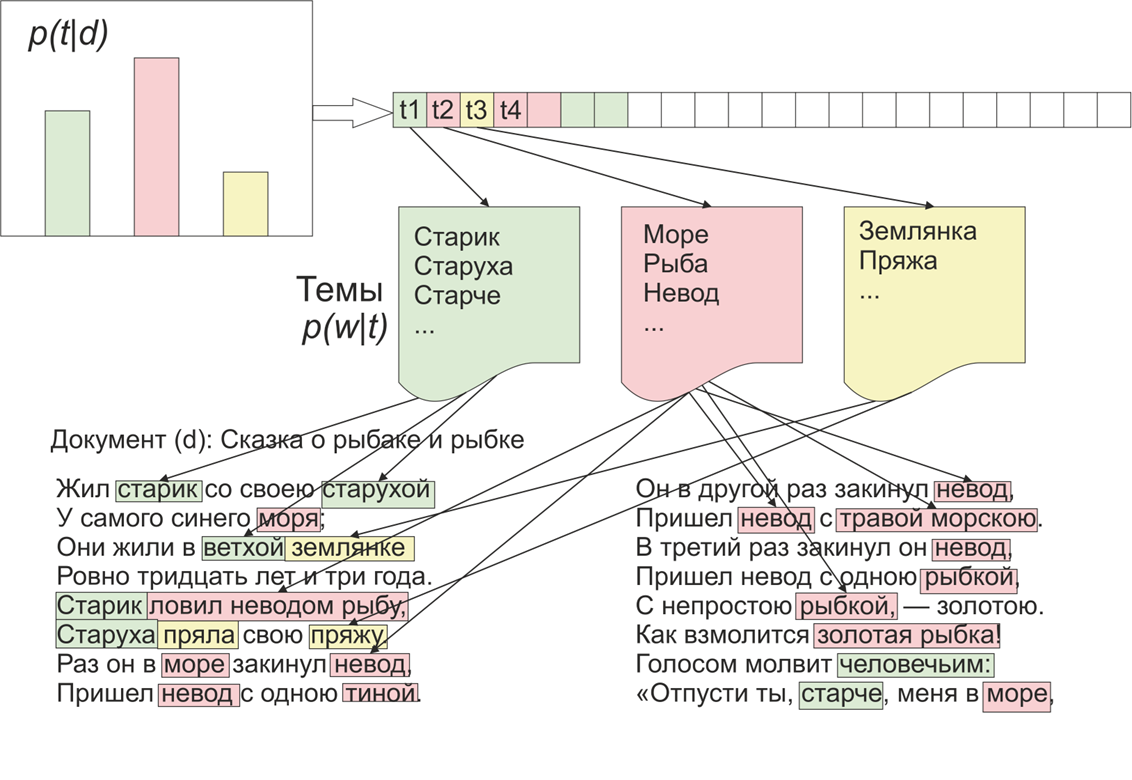

Бывает полезно в следующих случаях:


* Выделить темы в наборе текстов, агрегировать информацию
* Отследить динамику тем во времени
* Найти отношения между темами
* Облегчить анализ текстов




Формальное описание

* Есть коллекция документов D
* Каждый документ d из D состоит из термов (w1, …, wn)
* Необходимо определить:
    * темы
    * принадлежность документа к каждой из тем
    * насколько слова определяют тему


# BERTopic

[BERTopic repo](https://github.com/MaartenGr/BERTopic)

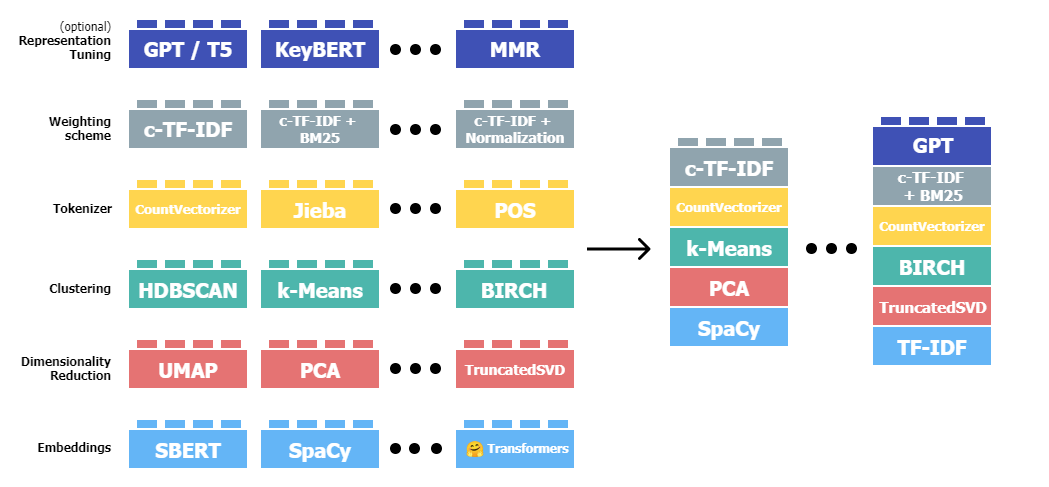

In [ ]:
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

### Построение эмбеддингов

По умолчанию `sentence-transformers`

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# embedding_model = spacy.load("en_core_web_md", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Снижение размерности

По умолчанию `UMAP` - позволяет сохранить часть локальной и глобальной структуры набора данных при уменьшении его размерности.

In [ ]:
dim_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# dim_model = PCA(n_components=5)
# dim_model = TruncatedSVD(n_components=5)
# dim_model = BaseDimensionalityReduction()

### Кластеризация

По умолчанию `HDBSCAN` -  может находить кластеры различной формы и умеет выявлять выбросы

In [ ]:
cluster_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# cluster_model = KMeans(n_clusters=50)
# cluster_model = AgglomerativeClustering(n_clusters=50)

### Токенизация

При использовании HDBSCAN для кластеризации можно предположить, что кластеры имеют разные плотности и формы. Значит, представление тем на основе центроидов может быть не самым подходящим и нужен метод представления тем, который практически не делает предположений об ожидаемой структуре кластеров.

Для этого сначала все документы кластера объединяются в очень длинный один документ. Затем генерируюется «мешок слов» с частотами каждого слова в каждом кластере. Таким образом, это представление «мешка слов» на уровне кластера, а не на уровне документа.



In [ ]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=5)

### Создание тем

Из сгенерированного «мешка слов» мы хотим знать, что отличает один кластер от другого.

Для этого можно использовать модифицированный `TF-IDF`

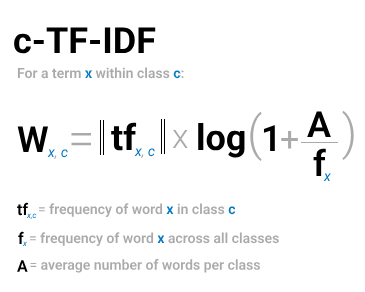

In [ ]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

### Fine-tuning

#### KeyBERTInspired

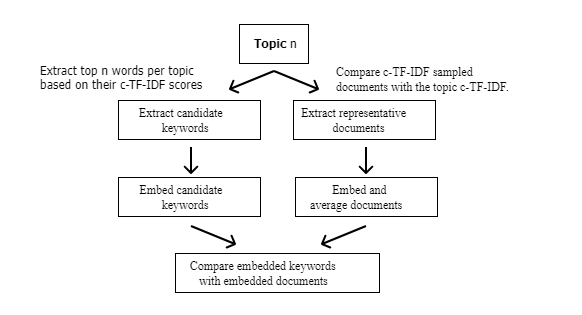

KeyBERT:

- С помощью BERT извлекаются эмбеддинги текстов.
- Затем для слов/фраз извлекаются эмбеддинги слов.
- Используя cosine similarity находятся слова/фразы, наиболее похожие на документ

In [ ]:
representation_model = KeyBERTInspired()

#### MaximalMarginalRelevance

Когда мы рассчитываем веса ключевых слов, мы обычно не учитываем, есть ли у нас уже похожие ключевые слова в теме.

Чтобы уменьшить избыточность и увеличить разнообразие ключевых слов, мы можем использовать MMR:

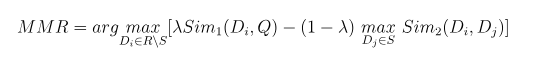

### Соберем все вместе

In [ ]:
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=dim_model,                     # Step 2 - Reduce dimensionality
  hdbscan_model=cluster_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [ ]:
%%time

topics, probs = topic_model.fit_transform(docs)

CPU times: user 1min 57s, sys: 1.49 s, total: 1min 59s
Wall time: 1min 43s


In [ ]:
topic_model.get_topic_info()[1:11]

,Topic,Count,Name,Representation,Representative_Docs
1,0,1839,0_hockey_rangers_stats_pens,"[hockey, rangers, stats, pens, league, buffalo...",[I would appreciate it if someone could volunt...
2,1,605,1_clipper_encryption_decrypt_cryptography,"[clipper, encryption, decrypt, cryptography, c...",[The following document summarizes the Clipper...
3,2,526,2_huh___,"[huh, , , , , , , , , ]","[\nYep.\n, \n \n ..."
4,3,472,3_palestinians_zionist_palestinian_palestine,"[palestinians, zionist, palestinian, palestine...",[Center for Policy Research writes...\n\n\n\n ...
5,4,444,4_scsi_disks_disk_toshiba,"[scsi, disks, disk, toshiba, ibm, bios, harddi...",[Computer Equipment Garage Sale:\n\nI've final...
6,5,422,5_vga_monitors_monitor_640x480,"[vga, monitors, monitor, 640x480, card, chipse...",[FOR IMMEDIATE RELEASE\n\nEditorial Contact:\n...
7,6,332,6_debate_censorship_hypocrite_insults,"[debate, censorship, hypocrite, insults, respo...",[}For those missing the context of this thrill...
8,7,317,7_investigation_witnesses_murder_fires,"[investigation, witnesses, murder, fires, surv...",[This was posted by Lyn Bates to the firearms-...
9,8,239,8_motorcycling_riding_motorcycle_ride,"[motorcycling, riding, motorcycle, ride, bike,...",[\n\n\tHOW TO GET A VERBAL WARNING FOR 146 IN ...
10,9,181,9_mustang_ford_mazda_camaro,"[mustang, ford, mazda, camaro, porsche, corvet...","[\n\n*nnnnnnnng* Thank you for playing, I cann..."


In [ ]:
topic_model.visualize_barchart(top_n_topics=30, n_words=10, title='Топ слов по темам')

### Визуализация токенов по темам

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True, batch_size=100)

In [ ]:
df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df

,My,brother,is,in,the,market,for,high,performance,video,card,that,supports,VESA,local,bus,with,2MB,RAM,Does,anyone,have,suggestions,ideas,on,Diamond,Stealth,Pro,Local,Bus,Orchid,Farenheit,1280,ATI,Graphics,Ultra,Pro,Any,other,high,performance,VLB,card,Please,post,or,email,Thank,you,Matt
5_vga_monitors_monitor_640x480,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.215,0.318,0.318,0.210,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.212,0.212,0.212,0.109,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.102,0.203,0.203,0.203,0.100,0.000,0.000,0.000,0.000,0.000,0.000
28_ram_vram_simms_sim,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
54_motherboard_motherboards_cpus_ram,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
85_processor_cpu_processors_motherboards,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.220,0.220,0.220,0.118,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
